In [0]:
from wbgps.analysis import plot_metrics
my_palette = sns.color_palette(['#ce343c','#EC8A61', '#89d4b4','#0081A7', '#72C9C8', '#547474', '#8a567a', '#743D55','#b25a97', '#efb953'])

PyPI package pandas has been installed already. The previously installed package is `pandas==1.3.1`. To resolve this issue, detach and re-attach the notebook to create a new environment or rename the package.

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col, desc, lit
from pyspark.sql import Window


start_baseline = '2020-02-01'
end_baseline = '2020-03-01'
start_date = '2020-02-01'
end_date = '2021-05-01'

results_dir = '/mnt/Geospatial/results/veraset/'

bins_wealth = [0, 0.4, 0.8, 1]
bins_dist = [0, 0.4, 0.8, 1]

countries = ['ID', 'PH', 'BR', 'CO', 'MX', 'ZA']
# countries = ['PH']

c_dates = {'BR': '2021-05-01',
           'CO': '2021-05-01',
           'ID': '2021-05-01',
           'MX': '2021-05-01',
           'PH': '2021-05-01',
           'ZA': '2021-05-01',
           'AR': '2021-05-01'}

activity_level = 0.2

hw = 49
ww = 49
wa = 3600
mph = 0.2
mpw = 0.2

ma = 28


labels_wealth = [x+' ('+str(int(bins_wealth[i]*100))+'%-'+str(int(bins_wealth[i+1]*100)) +'%)' for i, x in zip(range(len(bins_wealth)-1), ['Low', 'Medium', 'High'])]
labels_dist = [x+' ('+str(int(bins_dist[i]*100))+'%-'+str(int(bins_dist[i+1]*100)) +'%)' for i, x in zip(range(len(bins_dist)-1), ['Low', 'Medium', 'High'])]
country_capitals = {'MX': 'Mexico City', 'BR': 'São Paulo', 'CO': 'Bogota',
                    'PH': 'Quezon City [Manila]', 'ID': 'Jakarta', 'ZA': 'Johannesburg', 'AR': 'GBuenos Aires'}

In [0]:
# results = {}
# for country in countries:
#     print(country)

#     admins_by_country, admins_by_metro_area, pop_metro_areas = process_admin(
#         country)
#     capital_geomid = admins_by_metro_area[admins_by_metro_area.metro_area_name ==
#                                           country_capitals[country]].geom_id.unique().tolist()
#     durations_and_admins = compute_durations_and_admins(country, c_dates[country],
#                                                         activity_level=activity_level,
#                                                         hw=hw, ww=ww, wa=wa, mph=mph, mpw=mpw)
#     durations_and_admins.cache()
#     out1 = compute_durations_normalized_by_wealth_home(durations_and_admins, admins_by_country, labels_wealth, bins_wealth)
#     out2 = compute_durations_normalized_by_wealth_home_wealth_work(durations_and_admins, admins_by_country, labels_wealth, bins_wealth)
#     results[(country, 't_home')] = output(out1, column='H')
#     results[(country, 't_work')] = output(out1, column='W')
#     results[(country, 't_other')] = output(out1, column='O')
#     results[(country, 'rec')] = output(out1, column='R')
#     results[(country, 'comms')] = output(out1, column='C')
#     results[(country, 'comms_hw')] = output_hw(out2, column='C')
#     results[(country, 't_work_hw')] = output_hw(out2, column='W')

#     durations_and_admins.unpersist()
# # save results
# res2 = pd.DataFrame(columns=['state', 'measure',
#                              'wealth_label_home', 'date', 'mean', 'sem'])
# for key, res in results.items():
#     res_tmp = res.reset_index().copy()
#     res_tmp['state'], res_tmp['measure'] = key
#     res2 = res2.append(res_tmp, ignore_index=True)

# res2.to_csv(results_dir+'all_hw_weighted.csv')

In [0]:
ylabels = {'t_home': 'Time spent at home\n(relative change)', 't_home_capital': 'Time at home metro area\n(relative change)',
           't_other': 'Time at third places\n(relative change)', 't_other_capital': 'Time at third places\npeople living in metro area (relative change)',
           'rec': 'Share of people not\nleaving home (relative change)', 'rec_capital': 'Share of people not\nleaving home metro area (relative change)',
           't_work': 'Time spent at work\n(relative change)', 't_work_capital': 'Time at work metro area\n(relative change)',
           'comms': 'Share of commuters\n(relative change)', 'comms_capital': 'Share of commuters metro area\n(relative change)',
           't_work_hw': 'Time spent at work\n(relative change)', 't_work_hw_capital': 'Time at work metro area\n(relative change)',
           'comms_hw': 'Share of commuters\n(relative change)', 'comms_hw_capital': 'Share of commuters metro area\n(relative change)'}



results = pd.read_csv(results_dir+'all_hw_weighted.csv', parse_dates=[
                      'date'], usecols=['date', 'state', 'measure', 'wealth_label_home', 'mean', 'sem', 'wealth_label_work'])

ID
PH
BR
CO
MX
ZA

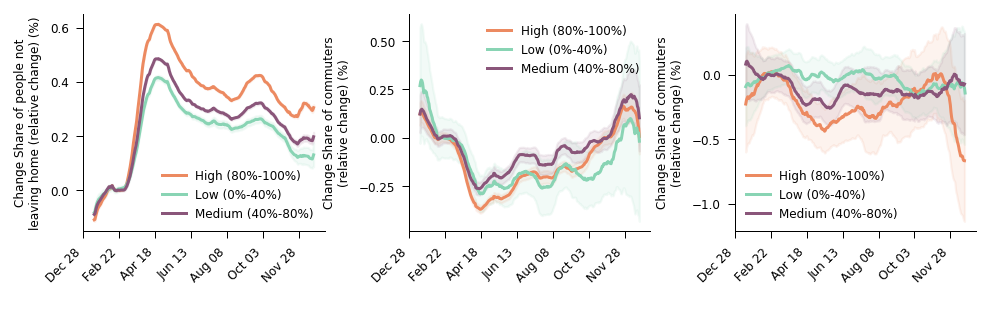

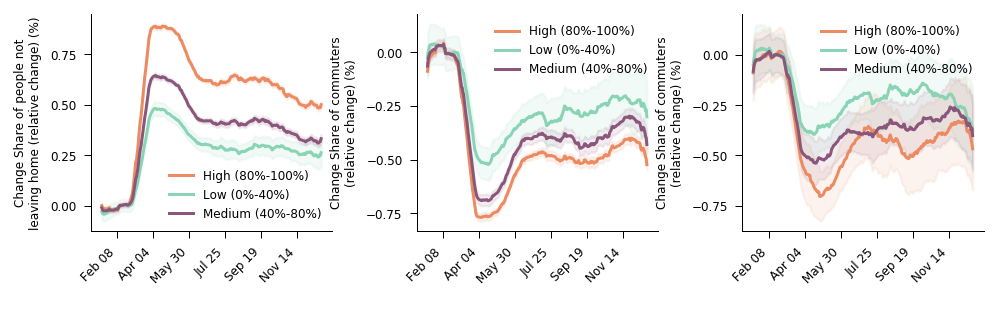

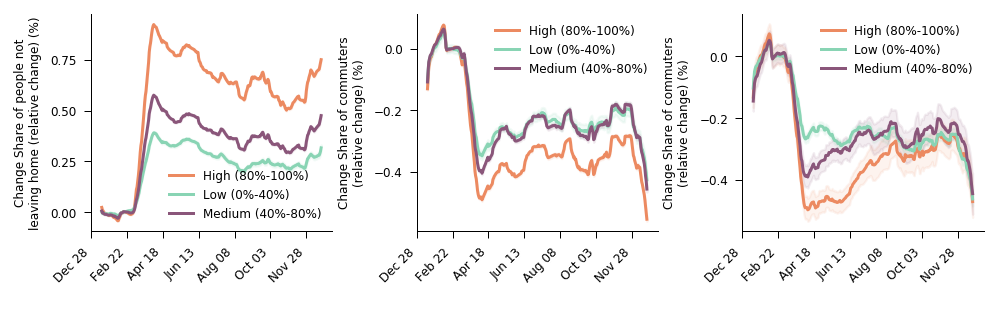

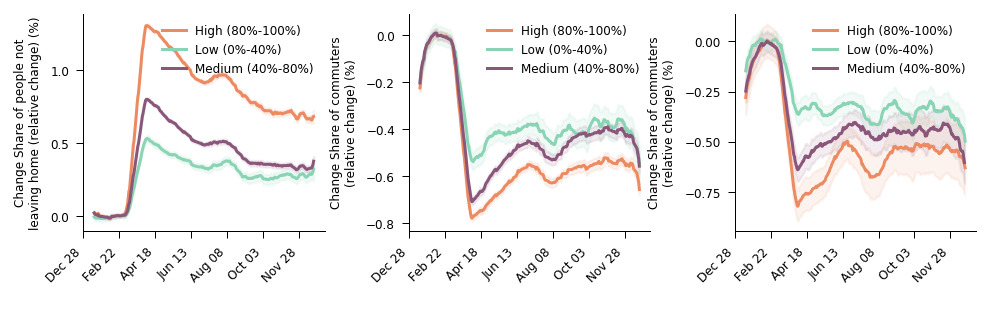

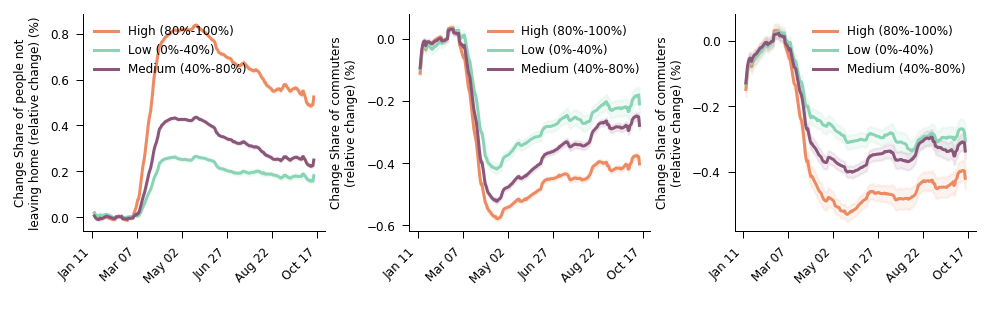

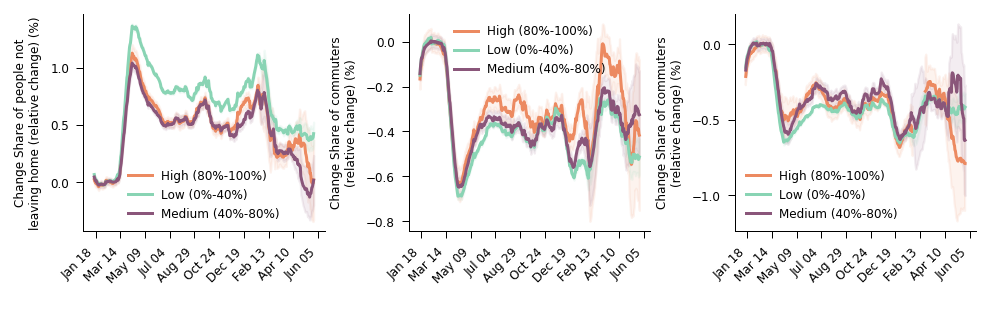

In [0]:
for state in results.state.unique():
  print(state)
  plot_metrics(results,state,other_groups=['wealth_label_home','wealth_label_work'])

ID
PH
BR
CO
MX
ZA

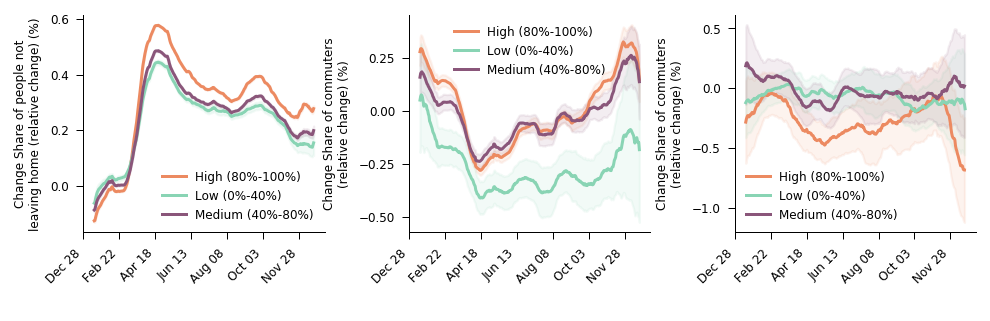

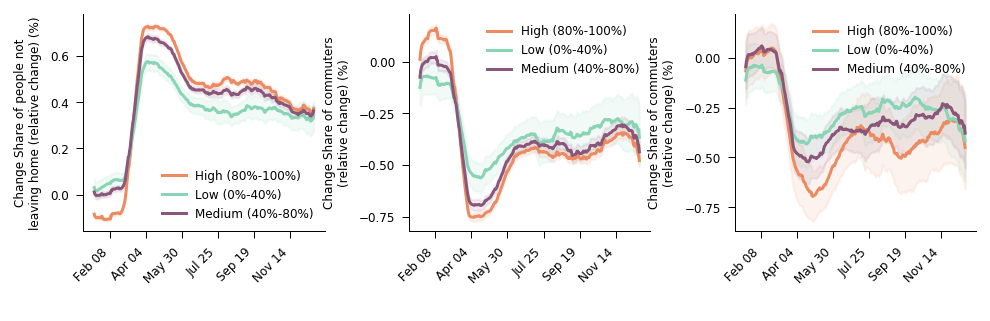

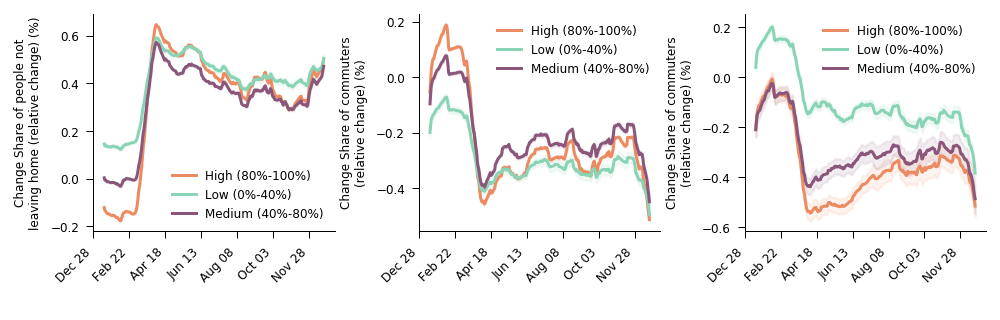

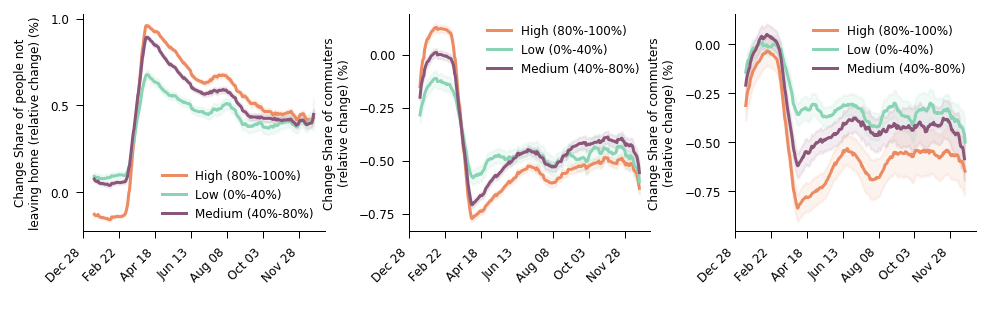

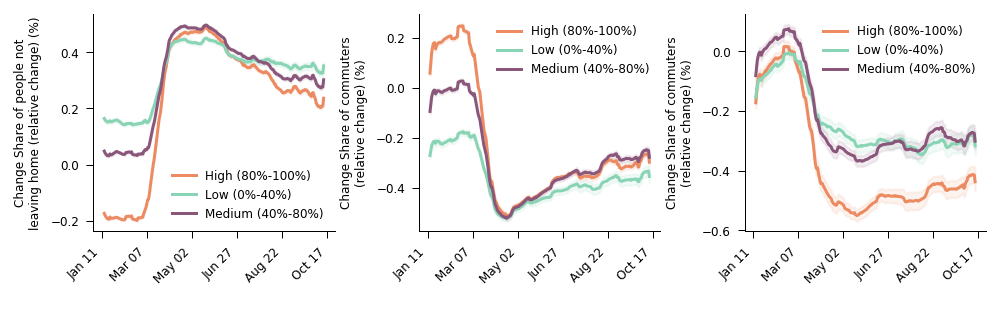

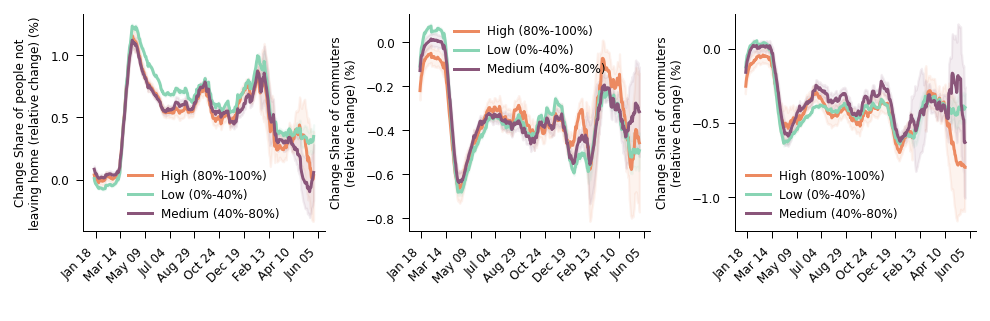

In [0]:
for state in results.state.unique():
  print(state)
  plot_metrics(results,state)